## If you want embed_dim flexible, then you better make prefix cnn flexible
## If using pretrained resnet, the grid_size and embedding dim is fixed.
### Better debug on MAE-pytorch repository

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import yaml
from PIL import Image
from torchvision.transforms import v2
import numpy as np
from mae_utils import *
from timm.models.layers import drop_path


In [2]:
def read_yaml_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = read_yaml_config('config.yaml')
print(config['PrefixResnet'])


{'depth': 6, 'kernel_size': '([3,3],[3,3],[3,3])', 'in_channel': 3, 'requires_grad': False}


In [3]:
class PrefixResnet(nn.Module):
    def __init__(self,args):
        super().__init__()
        self.model=self._build(args,pretrained=True)

    def forward(self,x):
        for layer in self.model:
            x=layer(x)
        return x
        
    def _build(self,args,pretrained):
        depth=args['depth']
        kernel_size=args['kernel_size']
        in_channel=args['in_channel']

        backbone=models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        if not pretrained:
            backbone=models.resnet18()
        
        module_list=nn.ModuleList()
        for i in range(depth):
            module_list.append(list(backbone.children())[i])

        #print(module_list)
        return module_list

class PrefixCNN(nn.Module):
    def __init__(self,args):
        super().__init__()
        self.model=self._build(args,pretrained=False)
        self.relu=nn.ReLU(inplace=True)
    def forward(self,x):

        return self.relu(self.model(x))
        
    def _build(self,args,pretrained):
        img_size=args['img_size']
        patch_size=args['patch_size'] #kernel_size
        in_channel=args['in_channel']
        out_channel=args['out_channel']
        pretrained_path=args['pretrained_model_path']

        #one layer Conv2d projection
        model=nn.Conv2d(in_channel,out_channel,kernel_size=patch_size,stride=patch_size)
        if pretrained and pretrained_path!="":
            model.load_state_dict(pretrained_model_path)

        return model



prefix_resnet=PrefixResnet(config['PrefixResnet'])
prefix_cnn=PrefixCNN(config['PrefixCNN'])


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_img="./COCOSearch18/images/bottle/000000009527.jpg"
transform=v2.Compose([v2.ToImage(), 
                      v2.RandomCrop((320,320)),
                       v2.ToDtype(torch.float32, scale=True)])
img=transform(Image.open(test_img)).unsqueeze(0).repeat(3,1,1,1)

result=prefix_cnn(img)
print(result.shape)


torch.Size([3, 768, 20, 20])


(82, 16)


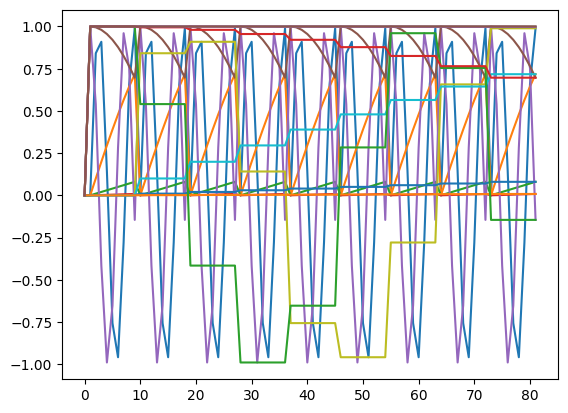

In [5]:
y=get_2d_sincos_pos_embed(16,9,True)
from matplotlib import pyplot as plot
print(y.shape)
plot.plot(y)
plot.show()

In [6]:

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.act2 = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # commit this for the orignal BERT implement 
        x = self.fc2(x)
        x = self.act2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, attn_head_dim=attn_head_dim)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values > 0:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x):
        
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


In [7]:
class MaskedViTEncoder(nn.Module):
    def __init__(
        self,
        args,
        img_size,
        patch_size,
        embed_dim,
        **kwargs
        ):
        
        super().__init__()

        grid_size=int(img_size // patch_size)

        self.cnn=PrefixCNN(args['PrefixCNN'])
        self.cnn.requires_grad=args['PrefixCNN']['requires_grad'] #fixed
        
        self.pos_embed=torch.tensor(get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=True, add_token=False)).unsqueeze(0).to(torch.float32)
        
        #CLS_TOKEN
        self.cls_token=nn.Parameter(torch.randn((1, 1, embed_dim)), requires_grad=True)
        #nn.init.uniform_(self.cls_token)
        
        vit_config=args['ViTEncoder']
        dpr = [x.item() for x in torch.linspace(0, vit_config['drop_path_rate'], vit_config['depth'])] # stochastic depth decay rule
        
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=vit_config['num_heads'], mlp_ratio=vit_config['mlp_ratio'], qkv_bias=vit_config['qkv_bias'], qk_scale=vit_config['qk_scale'],
                drop=vit_config['drop_rate'], attn_drop=vit_config['attn_drop_rate'], drop_path=dpr[i], norm_layer=nn.LayerNorm,
                init_values=0)
            for i in range(vit_config['depth'])])

        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, vit_config['num_classes']) if vit_config['num_classes'] > 0 else nn.Identity()
        
    def patchify(self):
        raise NotImplementedError

    def unpatchify(self):
        raise NotImplementedError

    def random_tube_masking(self, x, mask_ratio):
        if mask_ratio==0.0:
            return x, None
        N, L, D  = x.shape
        len_keep = int(L * (1 - mask_ratio))

        mask = np.hstack([np.zeros((N, L-len_keep),dtype=bool),
                          np.ones((N, len_keep),dtype=bool)])
        for row in mask:
            #inefficient approach
            np.random.shuffle(row)

        return x[mask].reshape(N,len_keep,-1), mask

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        batch_size = x.shape[0]

        #conv
        x=self.cnn(x).flatten(2).transpose(1, 2)
        print(x.shape)
        print(self.pos_embed.shape)
        
        #pos_embed
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask = self.random_tube_masking(x, mask_ratio)

        # append class token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_token = cls_token.repeat(batch_size, 1, 1)

        x = torch.concatenate((x, cls_token), dim=1)

        for block in self.blocks:
            x=block(x)

        x = self.norm(x)

        return x, mask

    def forward(self, x):
        x, _ = self.forward_encoder(x, mask_ratio=0.0)
        #x = x.mean(1)
        x = self.head(x[:, 0 ,: ]) #take cls token for classification

        return x


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mae_encoder=MaskedViTEncoder(args=config, img_size=320, patch_size=16, embed_dim=768)
embedded, mask = mae_encoder.forward_encoder(img, 0.3)
class_out = mae_encoder.forward(img)

masked=np.where(~mask)
vis=np.where(mask)
print(vis[1].shape[0]//3)
print(masked[0].shape[0]//3)

cuda:0
torch.Size([3, 400, 768])
torch.Size([1, 401, 768])
torch.Size([3, 400, 768])
torch.Size([1, 401, 768])
280
120


In [26]:
class MaskedViTDecoder(nn.Module):
    def __init__(
        self,
        args,
        img_size,
        patch_size,
        encoder_embed_dim=768,
        decoder_embed_dim=512,
        norm_pix_loss=True,
        masked_decoder_loss=True,
        reward_pred=False,
    ):
        super().__init__()

        vit_config=args['ViTDecoder']

        self.grid_size = int(img_size // patch_size)
        
        self.patch_size = patch_size
        self.encoder_embed_dim = encoder_embed_dim
        self.decoder_embed_dim = decoder_embed_dim
        
        self.norm_pix_loss = norm_pix_loss
        self.masked_decoder_loss = masked_decoder_loss
        self.reward_pred = reward_pred

        #mask_token
        self.mask_token=nn.Parameter(torch.randn((1, 1, decoder_embed_dim)), requires_grad=True)

        self.encoder_to_decoder = nn.Linear(encoder_embed_dim, decoder_embed_dim, bias=False)
        self.pos_embed=torch.tensor(get_2d_sincos_pos_embed(decoder_embed_dim, self.grid_size, cls_token=True, add_token=False)).unsqueeze(0).to(torch.float32)

        dpr = [x.item() for x in torch.linspace(0, vit_config['drop_path_rate'], vit_config['depth'])] # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=decoder_embed_dim, num_heads=vit_config['num_heads'], mlp_ratio=vit_config['mlp_ratio'], qkv_bias=vit_config['qkv_bias'], qk_scale=vit_config['qk_scale'],
                drop=vit_config['drop_rate'], attn_drop=vit_config['attn_drop_rate'], drop_path=dpr[i], norm_layer=nn.LayerNorm,
                init_values=0)
            for i in range(vit_config['depth'])])

        self.norm =  nn.LayerNorm(decoder_embed_dim)

        self.decoder_pred = nn.Linear(decoder_embed_dim, self.patch_size*self.patch_size*3) #decoder_dim->16*16*3
        
        '''
        self.decoder_pos_embed = tf.constant(
            common.mae_utils.get_2d_sincos_pos_embed(
                decoder_embed_dim,
                int(img_size // patch_size),
                cls_token=True,
                add_token=reward_pred,
            )[None],
            name="decoder_pos_embed",
            dtype=tf.float32,
        )
        '''

    def patchify(self, imgs):
        """
        imgs: [N, 3, H, W]
        x: [N, L, patch_size**2 * 3]
        """
        p = self.patch_size
        c = imgs.shape[1]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        batch_size, channels, height, width = imgs.shape
        patches = imgs.unfold(2, p, p).unfold(3, p, p)  # [N, 3, H/p, W/p, p, p]
        patches = patches.contiguous().view(batch_size, channels, -1, p * p)  # [N, 3, L, p*p]
        patches = patches.permute(0, 2, 3, 1).contiguous()  # [N, L, p*p, 3]
        patches = patches.view(batch_size, -1, p ** 2 * channels)  # [N, L, p*p*3]

        return patches

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 * 3)
        imgs: (N, H, W, 3)
        """
        p = self.patch_size
        c = x.shape[-1] // (p ** 2)
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        '''
        x = torch.reshape(x, [x.shape[0], h, w, p, p, c])
        x = torch.einsum("nhwpqc->nhpwqc", x)
        imgs = torch.reshape(x, [x.shape[0], c, h * p, h * p])
        '''
        x = x.reshape(x.shape[0], h, w, p, p, c)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        imgs = x.reshape(x.shape[0], h * p, h * p, c)
        imgs = imgs.permute(0, 3, 1, 2).contiguous()  # Change to (N, c, H, W)
        
        return imgs
        
    def forward_decoder(self, x, mask):
        # embed tokens
        x = self.encoder_to_decoder(x)

        #x without cls_token
        x_clsfree=x[:, 1:, :]

        #get mask and visible mask
        masked=np.where(~mask)
        vis=np.where(mask)
        
        N = x_clsfree.shape[0]
        L = vis[0].shape[0] // N #total//n_batch -> length per sample after masked
        L_ = self.grid_size**2 #complete length w/o cls_token

        #create a matrix of index and take dim=1 (j in [i][j][k])
        index_mat=torch.tensor(np.indices((N, L_, self.decoder_embed_dim)))[1] 

        #create index replacement for visible tokens
        vis_alter=np.arange(0,L)
        vis_alter=np.tile(np.expand_dims(vis_alter,axis=[0]).repeat(N,0).reshape(N * L, 1),(1,self.decoder_embed_dim))

        #for those masked, they should take the last masked token succeeded to the L rows, thus it's a replication of mask_token
        index_mat[masked] = L #checked->correct
        print("L:",L)
        #for those masked, they should be mapped to their origins
        index_mat[vis]=torch.tensor(vis_alter)

        #create mask_tokens but only one token will be used
        """is this legal?"""
        #mask_tokens=self.mask_token.repeat(N, L_-L, 1)
        mask_tokens=self.mask_token.repeat(N, 1, 1)
        x_=torch.concatenate((x_clsfree, mask_tokens), dim=1)
        print("x_.shape:",x_.shape)

        #gather upon index_mat on dim 1
        x_gathered=torch.gather(x_, 1, index_mat)
        print("x_gathered:",x_gathered.shape)
        
        x=torch.concatenate([x[:, :1, :], x_gathered], dim=1) #cls_token added

        '''
        # append mask token for reward prediction
        # we use same mask token for rew prediction. Maybe try different token?
        if self.reward_pred:
            rew_mask_token = self._cast(
                tf.tile(
                    mask_token,
                    [x.shape[0], 1, 1],
                )
            )
            x_ = tf.concat([x_, rew_mask_token], axis=1)
        '''

        # add pos embed
        x = x + self.pos_embed

        # apply Transformer blocks
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)

        x=self.decoder_pred(x[:, 1:, :]) #deprive cls_token

        '''
        if self.reward_pred:
            # predictor projection
            x = self.get(
                "vit_decoder_pred", tfkl.Dense, self.patch_size ** 2 * self.in_chans
            )(x[:, 1:-1, :])
            # reward projection
            y = self.get("vit_reward_pred", tfkl.Dense, 1)(x[:, -1:, :])
            return x, y
        else:
            # predictor projection
            x = self.get(
                "vit_decoder_pred", tfkl.Dense, self.patch_size ** 2 * self.in_chans
            )(x[:, 1:, :])
            return x
        '''
        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 1 is keep, 0 is remove
        """
        assert img.shape[0]==pred.shape[0]
        target = self.patchify(imgs)
        print(pred.shape)
        print(target.shape)
        if self.norm_pix_loss:
            mean = torch.mean(target, dim=-1, keepdim=True)
            var = torch.var(target, dim=-1, keepdim=True, unbiased=False)
            target = (target - mean) / torch.sqrt(var + 1.0e-6)

        loss = (pred - target) ** 2
        loss = torch.mean(loss, -1)  # [N, L], mean loss per patch

        if self.masked_decoder_loss:
            loss = (loss * torch.tensor(~mask)).sum() / mask.sum()
        else:
            loss = loss.mean()
            
        return loss

    def forward_reward_loss(self, rews, preds):
        raise NotImplementedError
        rews = tf.cast(rews, tf.float32)
        preds = tf.cast(preds, tf.float32)
        dist = common.SymlogDist(preds, 1, "mean")
        loss = -dist.log_prob(rews)
        return loss.mean()

In [27]:
mae_decoder = MaskedViTDecoder(config, img_size=320, patch_size=16)
fake_mask = np.zeros()
reconstruct = mae_decoder.forward_decoder(embedded, mask)
mae_decoder.unpatchify(reconstruct).shape
patched=mae_decoder.patchify(img)
mae_decoder.forward_loss(img, reconstruct, mask)
print(mask.shape)

L: 280
x_.shape: torch.Size([3, 281, 512])
x_gathered: torch.Size([3, 400, 512])
torch.Size([3, 400, 768])
torch.Size([3, 400, 768])
tensor([[ True, False, False,  ..., False,  True, False],
        [False, False, False,  ...,  True, False,  True],
        [ True, False, False,  ..., False, False, False]])
[[False  True  True ...  True False  True]
 [ True  True  True ... False  True False]
 [False  True  True ...  True  True  True]]
(3, 400)


In [ ]:
def Transpose(img):
    test_img=img.detach().cpu().numpy()
    mean=[0.485, 0.456, 0.406]
    #std=[0.229, 0.224, 0.225]
    std=[0.9, 0.9, 0.9]
    for ch in range(3):
        test_img[ch]*=std[ch]
        test_img[ch]+=mean[ch]

    test_img = np.clip(test_img, 0, 1)
    test_img *= 255
    test_img=test_img.astype(np.uint8).transpose(1,2,0)

    test_img=Image.fromarray(test_img)

    return test_img

In [ ]:
print(patched.shape)
unpatch=mae_decoder.unpatchify(patched)
print(unpatch.shape)
img
Transpose(unpatch[0])